 IMAGE-TO-IMAGE TRANSLATION USING GANs

In [15]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers # type: ignore
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
import numpy as np
import os


In [16]:
img1_path = "C:\\Users\\DELL\\Desktop\\image translation\\002.jpg"
img2_path = "C:\\Users\\DELL\\Desktop\\image translation\\022.jpg"

img1 = tf.image.decode_image(tf.io.read_file(img1_path))
img2 = tf.image.decode_image(tf.io.read_file(img2_path))

Preprocessing the Data

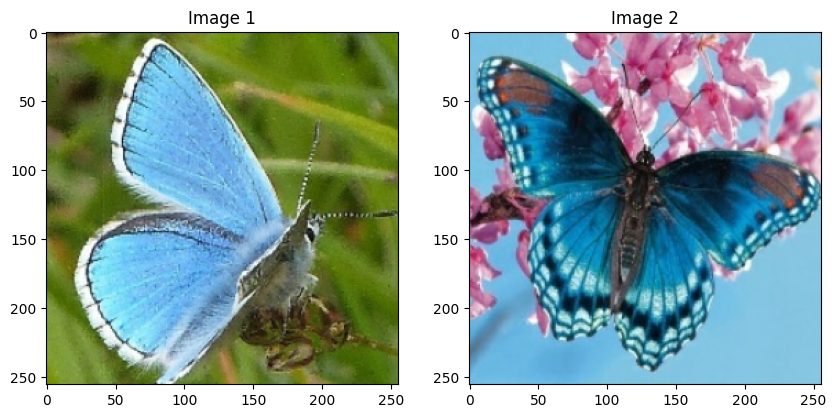

In [17]:

img_size = (256, 256)
img1 = tf.image.resize(img1, img_size) / 255.0
img2 = tf.image.resize(img2, img_size) / 255.0

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Image 1')
plt.imshow(img1.numpy())
plt.subplot(1, 2, 2)
plt.title('Image 2')
plt.imshow(img2.numpy())
plt.show()

Data Augmentation

In [18]:
def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image

img1 = augment_image(img1)
img2 = augment_image(img2)


Define Generator and Discriminator

In [19]:
def build_unet_generator():
    inputs = layers.Input(shape=(256, 256, 3))
    down1 = layers.Conv2D(64, 4, strides=2, padding='same', activation='relu')(inputs)
    down2 = layers.Conv2D(128, 4, strides=2, padding='same', activation='relu')(down1)
    down3 = layers.Conv2D(256, 4, strides=2, padding='same', activation='relu')(down2)
    
    up1 = layers.Conv2DTranspose(128, 4, strides=2, padding='same', activation='relu')(down3)
    up2 = layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu')(up1)
    up3 = layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')(up2)
    
    return tf.keras.Model(inputs=inputs, outputs=up3)

generator = build_unet_generator()

def build_patchgan_discriminator():
    inputs = layers.Input(shape=(256, 256, 3))
    down1 = layers.Conv2D(64, 4, strides=2, padding='same', activation='relu')(inputs)
    down2 = layers.Conv2D(128, 4, strides=2, padding='same', activation='relu')(down1)
    down3 = layers.Conv2D(256, 4, strides=2, padding='same', activation='relu')(down2)
    
    patch_output = layers.Conv2D(1, 4, strides=1, padding='same')(down3)
    
    return tf.keras.Model(inputs=inputs, outputs=patch_output)

discriminator = build_patchgan_discriminator()


Loss Functions and Optimizers

In [20]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = tf.losses.binary_crossentropy(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (100 * l1_loss)
    return total_gen_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = tf.losses.binary_crossentropy(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = tf.losses.binary_crossentropy(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


Training Functions

In [21]:

def train_step(real_x, real_y):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_y = generator(real_x, training=True)
        
        disc_real_y = discriminator(real_y, training=True)
        disc_fake_y = discriminator(fake_y, training=True)
        
        gen_loss = generator_loss(disc_fake_y, fake_y, real_y)
        disc_loss = discriminator_loss(disc_real_y, disc_fake_y)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs):
    for epoch in range(epochs):
        for real_x, real_y in dataset:
            gen_loss, disc_loss = train_step(real_x, real_y)
        print(f'Epoch {epoch + 1}, Gen Loss: {gen_loss}, Disc Loss: {disc_loss}')


Evaluation Functions

In [22]:
def generate_images(model, test_input):
    prediction = model(test_input, training=True)
    prediction = tf.clip_by_value(prediction, 0, 1)  
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Input Image')
    plt.imshow(test_input[0])
    plt.subplot(1, 2, 2)
    plt.title('Translated Image')
    plt.imshow(prediction[0])
    plt.show()

def save_generated_images(model, epoch, test_input, save_dir='generated_images'):
    prediction = model(test_input, training=False)
    prediction = tf.clip_by_value(prediction, 0, 1)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Input Image')
    plt.imshow(test_input[0])
    plt.subplot(1, 2, 2)
    plt.title(f'Translated Image at Epoch {epoch}')
    plt.imshow(prediction[0])
    plt.savefig(f'{save_dir}/epoch_{epoch}.png')
    plt.close()

def evaluate_image_quality(original, generated, win_size=7):
    original = np.array(original)
    generated = np.array(generated)
    generated = np.clip(generated, 0, 1) 
    ssim_value = ssim(original, generated, channel_axis=-1, win_size=win_size)
    psnr_value = psnr(original, generated)
    return ssim_value, psnr_value



In [23]:
# Example Usage
# Prepare dataset
dataset = tf.data.Dataset.from_tensor_slices((tf.expand_dims(img1, 0), tf.expand_dims(img2, 0)))
dataset = dataset.batch(1)

In [24]:
# Train the model
epochs = 10
train(dataset, epochs)

Epoch 1, Gen Loss: [[[58.370125 65.78056  65.78056  ... 60.451557 65.78056  65.78056 ]
  [59.89391  65.78056  65.78056  ... 65.78056  65.78056  65.78056 ]
  [65.78056  65.78056  65.78056  ... 65.78056  65.78056  65.78056 ]
  ...
  [65.78056  65.78056  65.78056  ... 65.78056  65.78056  65.78056 ]
  [65.78056  65.78056  65.78056  ... 65.78056  65.78056  65.78056 ]
  [65.78056  65.78056  65.78056  ... 65.78056  59.9384   65.78056 ]]], Disc Loss: [[[ 2.7460299  3.997804   4.225263  ...  4.756334   5.463024  16.118095 ]
  [ 3.8299282 16.118095  16.118095  ...  5.0073285  6.217694  16.118095 ]
  [ 3.386862   4.89239    3.7694087 ...  3.7125416  3.4982128 16.118095 ]
  ...
  [ 3.2238739 16.118095  16.118095  ...  4.5240555  4.680943  16.118095 ]
  [ 4.9083686 16.118095  16.118095  ... 16.118095  16.118095  16.118095 ]
  [16.118095  16.118095  16.118095  ...  4.5380125  4.564763   8.162389 ]]]
Epoch 2, Gen Loss: [[[55.812614 55.661736 55.59174  ... 55.565506 55.86257  56.165257]
  [55.650166 5

In [25]:
# Generate and save images
for epoch in range(epochs):
    for real_x, real_y in dataset:
        train_step(real_x, real_y)
    save_generated_images(generator, epoch, tf.expand_dims(img1, 0))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04862187..0.9513781].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04862187..0.9513781].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04862187..0.9513781].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04862187..0.9513781].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04862187..0.9513781].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04862187..0.9513781].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.

In [26]:
def evaluate_image_quality(original, generated, win_size=7):
    original = np.array(original)
    generated = np.array(generated)
    generated = np.clip(generated, 0, 1)  # Clip values to the range [0, 1]
    ssim_value = ssim(original, generated, data_range=1.0, channel_axis=-1, win_size=win_size)
    psnr_value = psnr(original, generated, data_range=1.0)
    return ssim_value, psnr_value


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04862187..0.9513781].


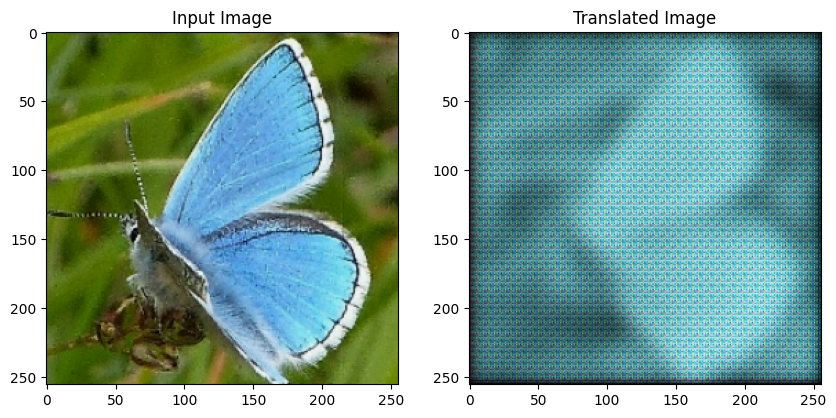

In [27]:
# Generate and display images
generate_images(generator, tf.expand_dims(img1, 0))